## The formula

$$ V^*(s_0) = \max_{a_{1,2,3...}} \mathbb{E}[\sum_{t=0}^{\infty}\gamma^t r(s_t,s_{t+1},a_t) ]$$

$$ V^*(s_t) = \max_{a_t} \mathbb{E}[r(s_t, s_{t+1}, a_t)]_{|s_t} + \gamma \max_{a_{t+1}} \int_S Prob(s_{t+2} | s_{t+1}, a_{t+1}) V^*(s_{t+1}) d s_{t+2}$$

Discrete action space case:

$$ V^*(s_t) = \max_{a_t} P_{s_t;a_t} R_{s_{t+1}} + \gamma \max P_{s_{t+2};a_{t+1}} V^*$$

Define $T$ as Bellman operator, solve for the fixed point: $ V = TV $ and we have $V^*$

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import random
from IPython import display
import time
%matplotlib inline
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

### Check here for the explanation of the game: https://gym.openai.com/envs/Taxi-v1/

In [3]:
# env = gym.make('FrozenLake-v0')
env = gym.make('Taxi-v2')
# env = gym.make('SpaceInvaders-v0')

[2017-11-30 01:39:24,064] Making new env: Taxi-v2


In [4]:
env.observation_space

Discrete(500)

In [5]:
def getP(C): #Get transition matrix from counts
    P = C/np.sum(C,axis=2)[:,:,np.newaxis]
    return(P)

In [6]:
V = np.zeros(env.observation_space.n) #Value
C = np.zeros([env.action_space.n,env.observation_space.n,env.observation_space.n])+0.01 #Count
R = np.zeros([env.action_space.n,env.observation_space.n,env.observation_space.n]) # Reward
rList = []
avgRList = []

In [7]:
P = getP(C) #Get transition matrix

In [9]:
episodeMax = 1500
gamma = 0.99
weight = 0.85
flag = True

for episode in range(episodeMax):
    display.clear_output(wait=False)
    print('Episode ',episode+1)
    state = env.reset()
    done = False
    while not done:
        statePre = state
        P =getP(C)
        #Compute reward
        VconditionStatePre  =np.einsum('ij,ij->i',R[:,statePre,:],P[:,statePre,:])+gamma*np.dot(P[:,statePre,:],V)
        a = np.argmax(VconditionStatePre+np.random.randn(env.action_space.n)*(1/(1.0+episode)))
        state,reward,done,info =  env.step(a)
        R[a,statePre,state] =  R[a,statePre,state]*(1-weight) + reward*weight
        C[a,statePre,state] += 1
        V[statePre,] = V[statePre,]*(1-weight)+(weight)*(R[a,statePre,state]+np.dot(P[a,statePre,:],V)*gamma)
        
    if done:
        rList.append(reward)
        if episode >100:
            avgR = sum(rList[-100:])/100
            avgRList.append(avgR)
            if avgR>9.7 and flag:
                flag = False
                print('Benchmark reached at least before episode '+str(episode))
        
        

Episode  1500


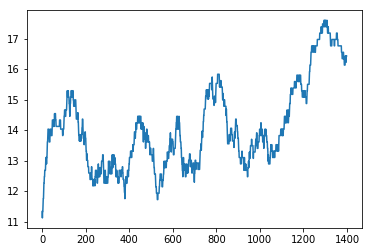

In [16]:
#Last-100 average score over training
plt.plot(avgRList)

Demostrate one episode

In [11]:
# env_mon = gym.wrappers.Monitor(env, 'tmp/Taxi-experiment-1',force=True)
env_mon = env

In [15]:
# Run this block of code to see the game plays rendered in real time.
playEpisode = 10
for i in range(playEpisode):
    display.clear_output(wait=True)
    print('Episode ',i+1) 
    time.sleep(0.8)
    state = env_mon.reset()
    done = False
    display.clear_output(wait=True)
    env_mon.render()
    stuck = False
    while not done:
            time.sleep(0.3)
            statePre = state
            VconditionStatePre  =np.einsum('ij,ij->i',R[:,statePre,:],P[:,statePre,:])+gamma*np.dot(P[:,statePre,:],V)
            
            
            if stuck:
                a = round(np.random.rand()*5)
            else:
                a = np.argmax(VconditionStatePre+np.random.randn(env_mon.action_space.n)*(1/(1.0+episode)))
                
            state,reward,done,info =  env_mon.step(a)
            display.clear_output(wait=True)
            env_mon.render()
            if state == statePre:
                stuck = True
            else:
                stuck = False
        
    

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [38]:
env.close()